In [46]:
import pandas as pd
import numpy as np

from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain

from gpx_parser import read_gpx, write_to_gpx
from metrics import (
    add_arc_distances_from_start,
    add_lengths_betwen_segments,
    add_angles_betwen_segments,
    create_track_dataframe,
    add_vector_segments,
    add_arc_lengths_betwen_segments,
    add_distances_from_start,
    add_oriented_angles_betwen_segments,
    add_velocities,
    make_plot,
    make_pairplt,
)
from viewer import open_gpx, view_df

Загружаем данные

In [47]:
# df = read_gpx("Korotkov_2023", ["Gvandra"])

df = read_gpx("Chashnikova_2024_row", ["Трек_КОЛЬЦО12"])

# df = read_gpx("bad_example", ["track"])

Посчитаем метрики на датафрейме.

*
*
*

In [48]:
add_arc_distances_from_start(df)
add_angles_betwen_segments(df)
add_lengths_betwen_segments(df)
# add_arc_lengths_betwen_segments(df)

p:\HikingSoft\GPXCleaner\spheric_geometry.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  B = (cos_b - cos_a * cos_c) / sin_a / sin_c


## 1. Кластеризация

Кластеризуем точки трека с помощью ```DBSCAN```. Параметр ```eps``` -- максимальное расстояние между точками одного кластера -- империчкски выбираем равным среднему расстоянию между точками.

При таком выборе параметра, очквидно, возникнут проблемы с удалением точек, улетевших очкуда-то далеко с трека (например, из-за глушилок или сбоев в работе gps). Но с ними будем разбираться потом

In [49]:
epsilon = df["lengths_betwen_segments"].mean() / 3

In [50]:
points = np.array(list(zip(df["lat"], df["lon"])))
db = DBSCAN(eps=epsilon, min_samples=2).fit(points)

Добавляем полученные метки классов в датафрейм.

In [51]:
labels = db.labels_
df['cluster'] = labels

## 2. Подсчёт оконных сумм

In [63]:
ns_rolling_window = [n for n in range(5, 200, 10)] # Размеры скользящего окна

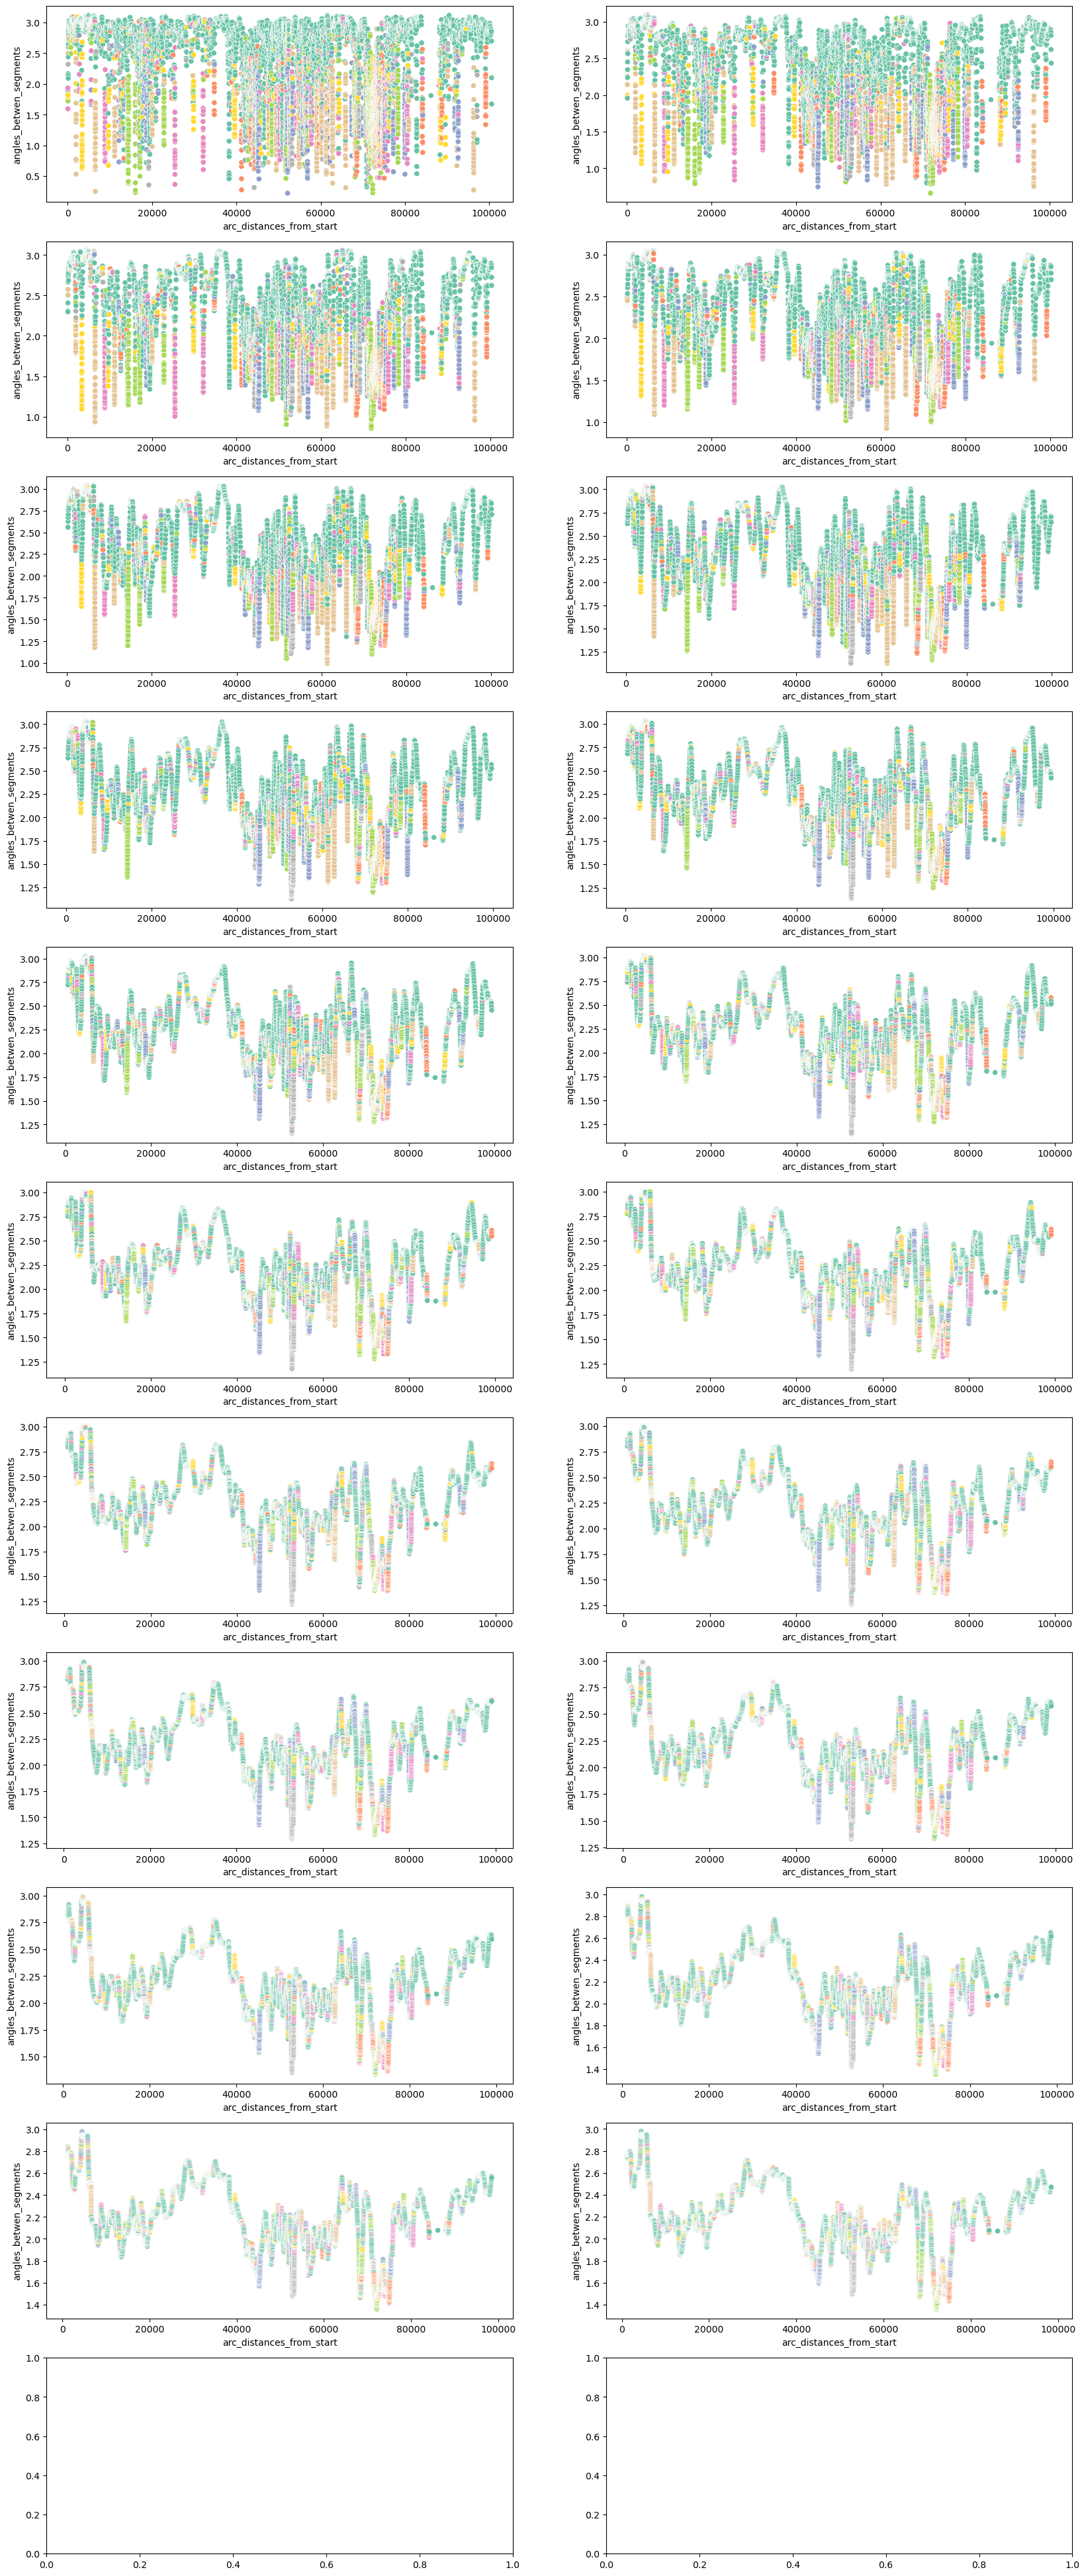

In [65]:
plot_cols = 2 # Задаём параметры сетки графиков
plot_rows = len(ns_rolling_window) // 2 + 1
fig, axs = plt.subplots(plot_rows, plot_cols, figsize=(20, 50))

for n, ax in zip(ns_rolling_window, chain(*axs)):
    rolling_window_sum = df["angles_betwen_segments"].rolling(window=n, center=True).mean()

    sns.scatterplot(
        data=df,
        x='arc_distances_from_start',
        y=rolling_window_sum,
        hue="cluster",
        ax=ax,
        palette='Set2',
        legend=None,
    )

plt.show()

По этим графикам, по идее нужно как-то подобрать размер скользящего окна получше

## 3. Pairplot

Тут пока что ничего интересного

In [54]:
# sns.pairplot(data=df, hue='cluster', height=10, palette='Paired')

## 4. Удаление точек

На глаз выбираем порог для оконных сумм и удаляем целиком все кластеры, хотя бы одна точка которых оказалась ниже порога (значение оконной суммы вокруг которой оказалось ниже порога)

Как подбирается значение ```n```? Не знаю пока что))

In [55]:
best_n = 50     # Выбранная ширина скользящего окна
threashold = 1.3 # Пороговое значение оконных сумм

Добавляем оконные суммы в датафрейм

In [56]:
df['rolling_sum'] = df["angles_betwen_segments"].rolling(window=best_n, center=True).mean()

Удаляем кластеры, содержащие плохие точки

In [57]:
bad_labels = df[df['rolling_sum'] < threashold]['cluster'].values
df['deleted'] = df['cluster'].isin(bad_labels)

clean_df = df[~df['deleted']] # Очищенный датафрейм

Превратим оставленные точки обратно в .gpx файл

In [58]:
write_to_gpx(clean_df, 'tracks/tmp/tmp.gpx')

Посмотрим, чем отличается очищенный трек от сырого

In [ ]:
# big_df = pd.concat([df, clean_df])

In [60]:
view_df(df)